## Import

In [50]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from torch.utils.data.dataset import Dataset
from torch.autograd import Variable

import pandas as pd
from PIL import Image
from PIL import ImageFilter

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from cv2 import cv2

## Hyperparameter

In [38]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
batch_size = 32
input_dim = 7
output_dim = 8
epochs = 100
lr_rate = 0.01

use_gpu = torch.cuda.is_available()


## File Path

In [12]:
train_sets = ["train_subset0.csv", "train_subset1.csv", "train_subset2.csv", "train_subset3.csv", "train_subset4.csv"]
test_sets = ["val_subset0.csv", "val_subset1.csv", "val_subset2.csv", "val_subset3.csv", "val_subset4.csv"]
images_folder = "./images/"
labels_folder = "./labels/"

## Data Histogram

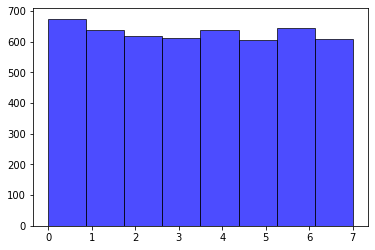

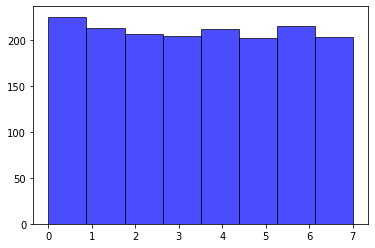

In [48]:
def DrawHistogram(data_path):
    imgpath_labels = pd.read_csv(data_path).query("Label<8").reset_index(drop=True)
    labels = np.asarray(imgpath_labels.iloc[:, 1])
    plt.hist(labels, bins=8, facecolor="blue", edgecolor="black", alpha=0.7)
    plt.show()

DrawHistogram(labels_folder + train_sets[0])
DrawHistogram(labels_folder + test_sets[0])

## Try Background removal

array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

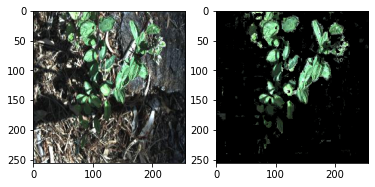

In [76]:
def Backgroud_remove(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))
    imask = mask>0
    green = np.zeros_like(image, np.uint8)
    green[imask] = image[imask]
    return green

img_for_bk_remove = Image.open(images_folder + "20160928-140314-0.jpg")
plt.subplot(1,2,1)
plt.imshow(np.array(img_for_bk_remove))
plt.subplot(1,2,2)
img_after_bk_remove = Backgroud_remove(np.array(img_for_bk_remove))
plt.imshow(img_after_bk_remove)
img_after_bk_remove.reshape((1,256*256*3))

## DataSet Class

In [77]:
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path, transforms=None, lda=None):
        iter = 0
        for path in csv_path:
            if iter == 0:
                self.data = pd.read_csv(path).query("Label<8")
            else:
                self.data = self.data.append(pd.read_csv(path).query("Label<8"))
            iter += 1
        self.data = self.data.reset_index(drop=True)
        self.labels = np.asarray(self.data.iloc[:, 1])
        self.transforms = transforms
        self.lda = lda
        self.imgs = []
        for index in range(self.data.iloc[:, 0].size):
            img_x = Image.open(images_folder + self.data.iloc[:, 0][index])
            img_x = Backgroud_remove(np.array(img_x))
            #img_x = img_x.convert('L')
            img_x = img_x.reshape((1,256*256*3))[0]
            self.imgs.append(img_x)
        self.imgs = np.array(self.imgs)
        # PCA tranform the images
        self.imgs = lda.transform(self.imgs)
 
    def __getitem__(self, index):
        single_image_label = self.labels[index]
        img = self.imgs[index].reshape(1,7)
        '''
        img = Image.open(images_folder + self.data.iloc[:, 0][index])
        img = img.convert('L')
        # edge detection
        # img = img.filter(ImageFilter.FIND_EDGES)
        '''
        # 将图像转换成 tensor
        if self.transforms is not None:
            img_as_tensor = self.transforms(img)
            # 返回图像及其 label
        
        return (img_as_tensor, single_image_label)
 
    def __len__(self):
        return len(self.data)

## Model

In [71]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        #self.linear2 = nn.Linear(4096, 256)
        #self.linear3 = nn.Linear(256, output_dim)

    def forward(self, x):
        out = self.linear1(x)
        # out = nn.functional.relu(out)
        #out = self.linear2(out)
        # out = nn.functional.relu(out)
        #out = self.linear3(out)
        # out = nn.functional.relu(out)
        return out

model = LogisticRegression(input_dim, output_dim)
print(use_gpu)
if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss() # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr = lr_rate)


True


## PCA and LDA

In [78]:
def generatePCA(train_path):
    imgpath_labels = pd.read_csv(train_path).query("Label<8").reset_index(drop=True)
    train_images = []
    for index in range(imgpath_labels.iloc[:, 0].size):
        img_x = Image.open(images_folder + imgpath_labels.iloc[:, 0][index])
        img_x = Backgroud_remove(np.array(img_x))
        #img_x = img_x.convert('L')
        img_x = img_x.reshape((1,256*256*3))[0]
        train_images.append(img_x)
    
    train_images = np.array(train_images)
    pca = PCA(n_components=900).fit(train_images)
    return pca

In [79]:
def generateLDA(train_path):
    imgpath_labels = pd.read_csv(train_path).query("Label<8").reset_index(drop=True)
    train_images = []
    train_labels = []
    for index in range(imgpath_labels.iloc[:, 0].size):
        img_x = Image.open(images_folder + imgpath_labels.iloc[:, 0][index])
        img_x = Backgroud_remove(np.array(img_x))
        #img_x = img_x.convert('L')
        img_x = img_x.reshape((1,256*256*3))[0]
        train_images.append(img_x)
        train_labels.append(imgpath_labels.iloc[:, 1][index])
    
    train_images = np.array(train_images)
    lda = LinearDiscriminantAnalysis(n_components=7).fit(train_images, train_labels)
    return lda

In [20]:
pca = generatePCA(labels_folder + train_sets[0])

In [80]:
lda = generateLDA(labels_folder + train_sets[0])

MemoryError: Unable to allocate 7.38 GiB for an array with shape (5038, 196608) and data type float64

## Training Process

### Load Data

In [74]:
train_data= DatasetFromCSV([labels_folder + train_sets[0]],transform,lda)
test_data = DatasetFromCSV([labels_folder + test_sets[0]],transform,lda)
 
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)

img,lab = next(iter(train_loader))
print(img.shape)
print(len(train_data))
print(len(test_data))

torch.Size([32, 1, 1, 7])
5038
1680


### Training

In [75]:
for epoch in range(int(epochs)):
    print('epoch {}'.format(epoch + 1))
    running_loss = 0.0
    running_acc = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 7)
        if use_gpu:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
        else:
            images = Variable(images)
            labels = Variable(labels)

        outputs = model(images.float())
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * labels.size(0)
        _, pred = torch.max(outputs.data, 1)
        num_correct = (pred == labels).sum()
        running_acc += num_correct.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
        epoch + 1,
        running_loss / (len(train_data)),
        running_acc / (len(train_data))
        ))
    
    # test the model
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, 7) 
        if use_gpu:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
        else:
            images = Variable(images)
            labels = Variable(labels)
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print(correct, total)
    print('accuracy of the model %.2f' % (100 * correct / total))

epoch 1
Finish 1 epoch, Loss: 0.267720, Acc: 0.969631
tensor(280, device='cuda:0') 1680
accuracy of the model 16.67
epoch 2
Finish 2 epoch, Loss: 0.188590, Acc: 0.981937
tensor(277, device='cuda:0') 1680
accuracy of the model 16.49
epoch 3
Finish 3 epoch, Loss: 0.187759, Acc: 0.981937
tensor(279, device='cuda:0') 1680
accuracy of the model 16.61
epoch 4
Finish 4 epoch, Loss: 0.187098, Acc: 0.981937
tensor(278, device='cuda:0') 1680
accuracy of the model 16.55
epoch 5
Finish 5 epoch, Loss: 0.186634, Acc: 0.981739
tensor(276, device='cuda:0') 1680
accuracy of the model 16.43
epoch 6
Finish 6 epoch, Loss: 0.186435, Acc: 0.981937
tensor(277, device='cuda:0') 1680
accuracy of the model 16.49
epoch 7
Finish 7 epoch, Loss: 0.186152, Acc: 0.981937
tensor(273, device='cuda:0') 1680
accuracy of the model 16.25
epoch 8
Finish 8 epoch, Loss: 0.186025, Acc: 0.981937
tensor(274, device='cuda:0') 1680
accuracy of the model 16.31
epoch 9
Finish 9 epoch, Loss: 0.185820, Acc: 0.981937
tensor(275, device